In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
data = pd.read_csv('data/kc_house_data.csv')

In [3]:
#drop columns seen as irrelevant
data.drop(columns = ['id','date','view','lat','long'], inplace=True)

In [4]:
#eliminate properties valued at $200000 or less and luxury homes from data set, 
#luxury homes defined as $500,000 and over 
#dropped 10041 rows
data = data[(data.price < 500000) & (data.price > 200000)]

In [5]:
#eliminate properties with 6 or more bedrooms and 4 or more bathrooms which were outliers in the data
#dropped 110 rows
data = data[(data.bedrooms < 6) & (data.bathrooms < 4)]

#eliminate properties with less than a full bathroom (defined as shower, bathtub, toilet, & sink) as judged
#to be undesirable. 
#dropped 48 rows
data = data[(data.bathrooms >= 1)]

In [6]:
#change sqft_basement, yr_renovated, and waterfront to binary categorical variables

#change the value ? to string 0
data['sqft_basement'] = data['sqft_basement'].replace(['?'],'0')
#convert datatype of sqft_basement column to float
data = data.astype({'sqft_basement': float})
#create new boolean column for whether property has a basement
data['has_base'] = np.where((data['sqft_basement'] > 0),1,0)
data.head()


#fill NaN values in yr_renovated column with 0
data['yr_renovated'].fillna(0, inplace=True)
#create boolean column for whether a property has been renovated
data['has_renov'] = np.where((data['yr_renovated'] > 0),1,0)
data.head()


#fill NaN values waterfront column with 0 meaning no waterfront view
data['waterfront'].fillna(0, inplace=True)
#convert waterfront to boolean values
data.waterfront = np.where((data['waterfront'] == 1),1,0)

In [7]:
#change values in floors columns to prepare for one hot encoding
def floor(value):
    if value == 1:
        return 1
    elif value == 1.5:
        return '1and_half'
    elif value == 2:
        return 2
    elif value == 2.5:
        return '2and_half'
    elif value == 3:
        return 3
    elif value == 3.5:
        return '3and_half'
       
data.floors = data.floors.apply(floor)

In [8]:
#dealing with the bathrooms predictor
#change values in bathrooms column to prepare for one hot encoding
def baths(value):
    if value == 1:
        return 1
    elif value < 2:
        return '1and_quart_plus'
    elif value == 2:
        return 2
    elif value < 3:
        return '2and_quart_plus'
    elif value == 3:
        return 3
    elif value > 3:
        return '3and_quart_plus'
data.bathrooms = data.bathrooms.apply(baths)

In [9]:
#convert datatype of columns bedrooms, bathrooms, floors, condition, and grade to prepare for one hot encoding
convert_dict = {'bedrooms': str, 'bathrooms': str, 'floors': str, 'condition':str, 'grade': str}
data = data.astype(convert_dict)

#create dummy variables for categoricals bedrooms, bathrooms, floors, condition, and grade
bedrooms_dum = pd.get_dummies(data['bedrooms'], prefix='bed', drop_first=True)
bathrooms_dum = pd.get_dummies(data['bathrooms'], prefix='bath', drop_first=True)
floors_dum = pd.get_dummies(data['floors'], prefix='fl', drop_first=True)
condition_dum = pd.get_dummies(data['condition'], prefix='cond', drop_first=True)
grade_dum = pd.get_dummies(data['grade'], prefix='gr', drop_first=True)

#remove orignial columns of dummy variables, add dummy columns
data = data.drop(['bedrooms', 'bathrooms', 'floors', 'condition', 'grade'], axis=1)
data = pd.concat([data, bedrooms_dum, bathrooms_dum, floors_dum, condition_dum, grade_dum], axis=1)


In [10]:
#dropping features: sqft_above for collinearity with sqft_living, sqft_basement and yr_renovated have binary 
#categoricals for representation, sqftliving15 and sqft_lot15 deemed superfluous
data.drop(['sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

In [11]:
#df with outliers in sqft_living and sqft_lot removed
# 1000 < sqft_living < 10000, 1000 < sqft_lot < 10000
dfOut = data[(data.sqft_living > 1000) & (data.sqft_living <= 3000) & (data.sqft_lot < 10000) & (data.sqft_lot > 1000)]


In [12]:
#log transform sqft_living
data_log = pd.DataFrame([])
data_log['log_sqft_living'] = np.log(dfOut['sqft_living'])

#scale price, sqft_lot and sqftliving_log
sqft_lot = dfOut['sqft_lot']
price = dfOut['price']

scaled_price = (price - min(price)) / (max(price) - min(price))
scaled_sqftlot = (sqft_lot - min(sqft_lot)) / (max(sqft_lot) - min(sqft_lot))
scaled_sqftliving = (data_log - np.mean(data_log)) / np.sqrt(np.var(data_log))

#df with scaled features only
data_scaled = pd.DataFrame([])
data_scaled['sqft_lot'] = scaled_sqftlot
data_scaled['sqft_living'] = scaled_sqftliving
data_scaled['price'] = scaled_price

In [13]:
#df to add log and scaled sqft_lot and sqft_living
scaled_dfOut = dfOut.copy()

#drop original price, sqft_lot and sqft_living
scaled_dfOut.drop(['price', 'sqft_lot', 'sqft_living'], axis=1, inplace=True)

#concat log and scaled sqft_lot and sqft_living
scaled_dfOut = pd.concat([scaled_dfOut, data_scaled], axis=1)

In [14]:
#convert zipcode to string, create dummy for zipcode, drop zipcode column and add dummy column
scaled_dfOut = scaled_dfOut.astype({'zipcode': str})
zip_dummy = pd.get_dummies(scaled_dfOut['zipcode'], prefix='zip', drop_first=True)
scaled_dfOut = scaled_dfOut.drop(['zipcode'], axis=1)
scaled_dfOut = pd.concat([scaled_dfOut, zip_dummy], axis=1)
scaled_dfOut.head()

,waterfront,yr_built,has_base,has_renov,bed_2,bed_3,bed_4,bed_5,bath_1and_quart_plus,bath_2,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,0,1955,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,1995,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1963,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
8,0,1960,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,0,2003,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
scaled_dfOut.columns

Index(['waterfront', 'yr_built', 'has_base', 'has_renov', 'bed_2', 'bed_3',
       'bed_4', 'bed_5', 'bath_1and_quart_plus', 'bath_2',
       'bath_2and_quart_plus', 'bath_3', 'bath_3and_quart_plus',
       'fl_1and_half', 'fl_2', 'fl_2and_half', 'fl_3', 'fl_3and_half',
       'cond_2', 'cond_3', 'cond_4', 'cond_5', 'gr_11', 'gr_4', 'gr_5', 'gr_6',
       'gr_7', 'gr_8', 'gr_9', 'sqft_lot', 'sqft_living', 'price', 'zip_98002',
       'zip_98003', 'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008',
       'zip_98010', 'zip_98011', 'zip_98014', 'zip_98019', 'zip_98022',
       'zip_98023', 'zip_98024', 'zip_98027', 'zip_98028', 'zip_98029',
       'zip_98030', 'zip_98031', 'zip_98032', 'zip_98033', 'zip_98034',
       'zip_98038', 'zip_98042', 'zip_98045', 'zip_98052', 'zip_98053',
       'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059', 'zip_98065',
       'zip_98070', 'zip_98072', 'zip_98074', 'zip_98075', 'zip_98077',
       'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105', 'zip_9

In [15]:
#scikit-learn model for scaled df with dummied zipcode
#train-test split, model with scikit-learn
y = scaled_dfOut.price
X = scaled_dfOut.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model = LinearRegression()
model.fit(X_train, y_train)

y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 5999 rows and 97 columns
y_train is a Series with 5999 values
The training mean squared error:  0.021839704893141108
The test mean squared error:  0.02256146496108971
The training RSME:  0.1477826271695733
The test RSME:  0.15020474347066975


In [16]:
#statsmodels model for scaled df 
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     142.6
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:16:50   Log-Likelihood:                 2958.0
No. Observations:                5999   AIC:                            -5726.
Df Residuals:                    5904   BIC:                            -5089.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.4501      0.334      1.347      0.178      -0.205       1.105
waterfront            4.642e-13   1.51e-12      0.307      0.759    -2.5e-12    3.43e-12
yr_built                -0.0002      0.000     -1.131      0.258      -0.000       0.000
has_base                -0.0197      0.005     -3.662      0.000      -0.030      -0.009
has_renov                0.0515      0.015      3.537      0.000       0.023       0.080
bed_2                    0.0291      0.035      0.832      0.406      -0.039       0.098
bed_3                    0.0312      0.035      0.898      0.369      -0.037       0.099
bed_4                    0.0399      0.035      1.138      0.255      -0.029       0.109
bed_5                    0.0190      0.036      0.522      0.601      -0.052       0.090
bath_1and_quart_plus    -0.0023      0.007     -0.337      0.736      -0.016       0.011
bath_2                  -0.0004      0.008     -0.049      0.961      -0.016       0.016
bath_2and_quart_plus     0.0361      0.009      4.019      0.000       0.018       0.054
bath_3                   0.0219      0.016      1.392      0.164      -0.009       0.053
bath_3and_quart_plus     0.0171      0.018      0.972      0.331      -0.017       0.052
fl_1and_half            -0.0085      0.009     -0.995      0.320      -0.025       0.008
fl_2                    -0.0055      0.008     -0.731      0.465      -0.020       0.009
fl_2and_half            -0.0133      0.040     -0.329      0.742      -0.092       0.066
fl_3                    -0.0849      0.016     -5.294      0.000      -0.116      -0.053
fl_3and_half             0.1471      0.106      1.381      0.167      -0.062       0.356
cond_2                   0.1823      0.152      1.196      0.232      -0.116       0.481
cond_3                   0.2295      0.150      1.530      0.126      -0.065       0.524
cond_4                   0.2552      0.150      1.701      0.089      -0.039       0.549
cond_5                   0.2942      0.150      1.959      0.050      -0.000       0.589
gr_11                 2.839e-15   6.41e-16      4.427      0.000    1.58e-15     4.1e-15
gr_4                 -2.487e-15   5.96e-16     -4.171      0.000   -3.66e-15   -1.32e-15
gr_5                    -0.4567      0.111     -4.109      0.000      -0.675      -0.239
gr_6                    -0.3358      0.106     -3.161      0.002      -0.544      -0.128
gr_7                    -0.2777      0.106     -2.621      0.009      -0.485      -0.070
gr_8                    -0.1919      0.106     -1.813      0.070      -0.399       0.016
gr_9                    -0.0600      0.106     -0.564      0.572      -0.269       0.149
sqft_lot                 0.0553      0.012      4.582      0.000       0.032       0.079
sqft_living              0.0970      0.003     29.799    

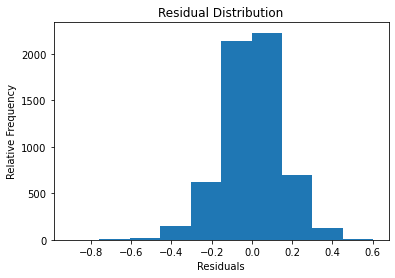

In [19]:
plt.hist(model.resid);
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Relative Frequency');

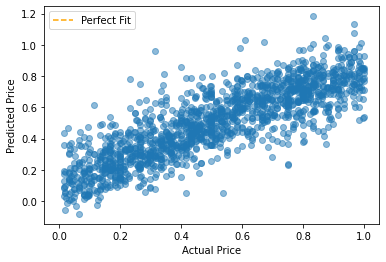

In [20]:
preds = model.predict(X_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

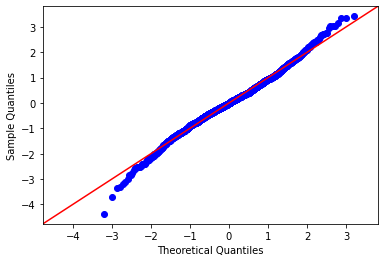

In [21]:
import statsmodels.api as sm
import scipy.stats as stats
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [ ]:
#function to 'unlog' a feature
def inv_normalize_price(feature_normalized):
"""
input the standard normal scaled target feature as an array 
output the same array without the standard normal scale
"""
    mu = df_log['price_log'].mean()
    sd = df_log['price_log'].std()
    return sd*feature_normalized + mu



In [ ]:
#function to 'unstandardize' a feature
scaled_price = (price - min(price)) / (max(price) - min(price))


price = scaled_price